<a href="https://colab.research.google.com/github/pravinkr/vgg16-cifar10-with-keras/blob/master/cifar_10_with_VGG16_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Simple CNN model for CIFAR-10 dataset
import numpy as np

# Simple CNN model for CIFAR-10
import numpy as np
import os
from keras.datasets import cifar10, cifar100
from keras.models import Sequential, Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.initializers import glorot_uniform
from keras import backend as K

from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

import skimage
from skimage.util import img_as_ubyte


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#model_type = 'Alexnet'
#model_type = 'ResNet50'
model_type = 'vgg16'

In [0]:
model_home_dir = os.path.join(os.getcwd(), 'My Drive','MLProjects',model_type)
print(model_home_dir)
if not os.path.isdir(model_home_dir):
    print('Inside mkdir')
    os.makedirs(model_home_dir)

#save_dir = os.path.join(model_home_dir, 'saved_models')
#save_dir

/content/My Drive/MLProjects/vgg16
Inside mkdir


In [0]:
#Defining Variables

#Data set information
DATASET = 'cifar-10'
#DATASET = 'cifar-100'
input_shape=(32,32,3)

if DATASET == 'cifar-10':
  num_classes = 10
elif DATASET == 'cifar-100':
  num_classes = 100

#Model Parameters



epochs = 200
lrate = 0.01
decay = lrate/epochs
batch_size = 32

data_augmentation = False
flow_from_dir = False

subtract_mean = True
seed = 7
np.random.seed(seed)

validate_dir = os.path.join("data","test")
train_dir = os.path.join("data","train")

# Prepare model model saving directory.
save_dir = os.path.join(model_home_dir, 'saved_models')

#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print("Model Type: ",model_type)
print("Model File: ",filepath)

Model Type:  vgg16
Model File:  /content/My Drive/MLProjects/vgg16/saved_models/cifar-10_vgg16_model.{epoch:03d}.h5


In [0]:
if flow_from_dir:
  if DATASET == 'cifar-10':
    %pip install cifar2png
    %cifar2png cifar10 "data"

170500096/170498071 [==============================] - 2s 0us/step


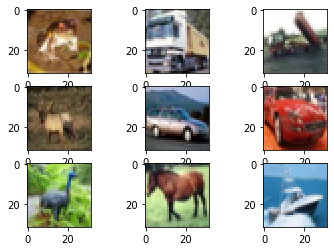

In [0]:
if not flow_from_dir:
  #load data
  if DATASET == 'cifar-10':
    (X_train, y_train),(X_test,y_test) = cifar10.load_data()
    X_train.shape, X_test.shape, X_train.shape[1:],X_train.dtype
  elif DATASET == 'cifar-100':
    (X_train, y_train),(X_test,y_test) = cifar100.load_data()
    X_train.shape, X_test.shape, X_train.shape[1:],X_train.dtype

  #Plot data
  for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(X_train[i])
  plt.show() 
  


In [0]:
def convert_to_imagenet_size(images):
  tmp_images = []
  for image in images:
    image = skimage.transform.resize(image,(224,224),mode='constant')
    image = img_as_ubyte(image)
    tmp_images.append(image)
  return np.array(tmp_images)

In [0]:
#Data Normalization
if not flow_from_dir:
  if not data_augmentation:
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = X_train/255.
    X_test = X_test/255.

    if subtract_mean:
      X_train_mean = np.mean(X_train)
      X_train -= X_train_mean
      X_test_mean = np.mean(X_test)
      X_test -= X_test_mean

  print(y_train.shape, y_test.shape)

(50000, 1) (10000, 1)


In [0]:
if not flow_from_dir:
  y_train = np_utils.to_categorical(y_train)
  y_test = np_utils.to_categorical(y_test)
  print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


In [0]:
#num_classes = y_train.shape[1]
#input_shape=X_train.shape[1:]

input_shape,num_classes

((32, 32, 3), 10)

In [0]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
def ResNet50(input_shape=(32, 32, 3), classes=10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((1,1), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
def vgg16(input_shape=(32,32,3), num_classes=10):
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  #model.add(Dropout(0.3))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=num_classes, activation="softmax"))

  return model

In [0]:
#Define Alexnet Model
def AlexnetModel(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes,activation='softmax'))

  #model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  #model.summary()
  return model

In [0]:
def get_model(input_shape,num_classes):
  # Create the model - Normal model with CNN, dropouts and MaxPooling.
  # This model gives accuracy of 77% on the test set after 25 epochs

  model = Sequential()

  #model.add(Conv2D(32,(3,3),input_shape=(32,32,3),padding='same',activation='relu'))
  model.add(Conv2D(32,(3,3),input_shape=input_shape,padding='same',activation='relu'))
  model.add(Dropout(0.2))

  model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dropout(0.2))

  model.add(Dense(1024,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(num_classes,activation='softmax'))

  return model



In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]


In [0]:
#model = get_model(input_shape,num_classes)
if model_type == 'Alexnet':
  #input_shape = (224,224,3)
  model = AlexnetModel(input_shape,num_classes)
elif model_type == 'ResNet50':
  model = ResNet50(input_shape,num_classes)
elif model_type == 'vgg16':
  model = vgg16(input_shape,num_classes)
else:
  model = get_model(input_shape,num_classes)

# Compile model

#optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss= 'categorical_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
print("Model Summary of ",model_type)
print(model.summary())



Model Summary of  vgg16
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (

In [0]:
if data_augmentation:
	print('Using real-time data augmentation.')
	# This will do preprocessing and realtime data augmentation:
	datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.2,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.2,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).


if not flow_from_dir:
	if not data_augmentation:
		print('Not using data augmentation.')
		history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=callbacks)
	else:   
		print("model using data from downloaded dataset in memoory")
		datagen.fit(X_train)
		# Fit the model on the batches generated by datagen.flow().
		history = model.fit_generator(datagen.flow(X_train, y_train,
                                 batch_size=batch_size),
                                 epochs=epochs,
                                 validation_data=datagen.flow((X_test, y_test),batch_size=batch_size),
                                 workers=4,
                                 callbacks=callbacks)
  
	scores = model.evaluate(X_test, y_test, verbose=1)

else:
	# generator for reading train data from folder

	print('Model fit using flow from directory')


	train_generator = datagen.flow_from_directory(
      train_dir,
      target_size = (224, 224),
      color_mode = 'rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle=False,
      seed=42
      )
	#
	# generator for reading validation data from folder

	validation_generator = datagen.flow_from_directory(
      validate_dir,
      target_size = (224, 224),
      color_mode = 'rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle=False,
      seed=42)
  
	STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
	STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
  
	history = model.fit_generator(generator=train_generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=validation_generator,
                validation_steps=STEP_SIZE_VALID,
                epochs=10,
                callbacks=callbacks
                )
  
	scores = model.evaluate_generator(generator=validation_generator,
                           steps=STEP_SIZE_VALID, verbose=1)

	#Predict the output
	''' Use when to Predict the output
	STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
	test_generator.reset()
	pred=model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

	'''
# Save model and weights



# Score trained model.

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Not using data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, validate on 10000 samples
Epoch 1/200





Learning rate:  0.001
50000/50000 [==============================] - 176s 4ms/step - loss: 2.3029 - acc: 0.0973 - val_loss: 2.3026 - val_acc: 0.1000

Epoch 00001: val_acc improved from -inf to 0.10000, saving model to /content/My Drive/MLProjects/vgg16/saved_models/cifar-10_vgg16_model.001.h5
Epoch 2/200
Learning rate:  0.001
50000/50000 [==============================] - 167s 3ms/step - loss: 2.3028 - acc: 0.0976 - val_loss: 2.3026 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.10000
Epoch 3/200
Learning rate:  0.001
50000/50000 [==============================] - 167s 3ms/step - loss: 2.3028 - acc: 0.0968 - val_loss: 2.3026 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.10000
Epoch 4/200
Learning rate:  0.001
50000/50000 [==============================] - 167s 3ms

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


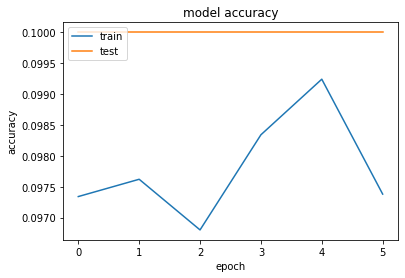

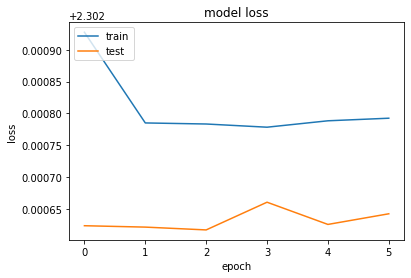

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()